# Artificial Neural Network

## revue selon https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-09-05 18:12:16.171506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 18:12:16.182773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 18:12:16.186086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 18:12:16.195138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 18:12:17.272850: W tensorflow/compiler/tf2

In [2]:
tf.version.VERSION

'2.17.0'

In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Part 1 - Data Preprocessing

### Importing the dataset, ignoring non impacting columns

In [4]:
raw_df = pd.read_csv("Churn_Modelling.csv")
#X = dataset.iloc[:, 3:-1].values
#y = dataset.iloc[:, -1].values

#### Un peu de stats

In [5]:
raw_df.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

In [6]:
neg, pos = np.bincount(raw_df['Exited'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 10000
    Positive: 2037 (20.37% of total)



In [45]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('RowNumber')
cleaned_df.pop('CustomerId')
cleaned_df.pop('Surname')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Balance'] = np.log(cleaned_df.pop('Balance')+eps)
cleaned_df['Log EstimatedSalary'] = np.log(cleaned_df.pop('EstimatedSalary')+eps)

Is there any missing value?

In [46]:
cleaned_df.shape[0] > cleaned_df.count() 

CreditScore            False
Geography              False
Gender                 False
Age                    False
Tenure                 False
NumOfProducts          False
HasCrCard              False
IsActiveMember         False
Exited                 False
Log Balance            False
Log EstimatedSalary    False
dtype: bool

In [47]:
cleaned_df.describe()

CreditScore           Age        Tenure  NumOfProducts    HasCrCard  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.00000   
mean     650.528800     38.921800      5.012800       1.530200      0.70550   
std       96.653299     10.487806      2.892174       0.581654      0.45584   
min      350.000000     18.000000      0.000000       1.000000      0.00000   
25%      584.000000     32.000000      3.000000       1.000000      0.00000   
50%      652.000000     37.000000      5.000000       1.000000      1.00000   
75%      718.000000     44.000000      7.000000       2.000000      1.00000   
max      850.000000     92.000000     10.000000       4.000000      1.00000   

       IsActiveMember        Exited   Log Balance  Log EstimatedSalary  
count    10000.000000  10000.000000  10000.000000         10000.000000  
mean         0.515100      0.203700      4.942786            11.208336  
std          0.499797      0.402769      8.924006             1.000421  
min          0.000000      0.000000     -6.907755             2.449366  
25%          0.000000      0.000000     -6.907755            10.839622  
50%          1.000000      0.000000     11.484511            11.514863  
75%          1.000000      0.000000     11.757002            11.914304  
max          1.000000      1.000000     12.432802            12.206035

### Splitting the dataset into the Training, Validation and Test sets

In [48]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [75]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Exited')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Exited')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Exited')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

check distribution of the different sets

In [76]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.2072
Average class probability in validation set: 0.1938
Average class probability in test set:       0.2005


In [77]:
train_df

CreditScore Geography  Gender  Age  Tenure  NumOfProducts  HasCrCard  \
4765          630     Spain  Female   49       1              2          0   
2593          692   Germany    Male   53       7              2          0   
3455          842    France    Male   29       8              2          1   
6136          780     Spain  Female   33       6              1          1   
9749          533    France  Female   35       8              2          1   
...           ...       ...     ...  ...     ...            ...        ...   
8379          434     Spain    Male   55       6              1          0   
7545          732    France    Male   26       7              2          1   
5148          731     Spain    Male   70       3              2          1   
7001          681   Germany    Male   48       5              2          0   
1357          591    France    Male   43       3              2          0   

      IsActiveMember  Log Balance  Log EstimatedSalary  
4765               1    -6.907755            12.000636  
2593               0    11.924551            11.693722  
3455               1    -6.907755            11.723487  
6136               1    11.888485            11.948587  
9749               1    -6.907755            12.143666  
...              ...          ...                  ...  
8379               1    -6.907755            11.205885  
7545               0    -6.907755            11.947073  
5148               1    -6.907755            11.857796  
7001               0    11.847356            11.199128  
1357               1    -6.907755            12.200690  

[6400 rows x 10 columns]

In [78]:
train_features.shape

(6400, 10)

### ⚠ Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export ⚠

### Encoding categorical data

Label Encoding the "Gender" column and One Hot Encoding the "Geography" column

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [86]:
encoder = ColumnTransformer(
    transformers=[( 'onehotenc', OneHotEncoder(sparse_output=False), [1]), 
                  ( 'labelenc', OrdinalEncoder(), [2])], 
    remainder='passthrough')

train_features = encoder.fit_transform(train_features)
val_features = encoder.transform(val_features)
test_features = encoder.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (6400, 1)
Validation labels shape: (1600, 1)
Test labels shape: (2000, 1)
Training features shape: (6400, 12)
Validation features shape: (1600, 12)
Test features shape: (2000, 12)


### Feature Scaling

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (6400, 1)
Validation labels shape: (1600, 1)
Test labels shape: (2000, 1)
Training features shape: (6400, 12)
Validation features shape: (1600, 12)
Test features shape: (2000, 12)


## Part 2 - Building the ANN

### Initiate the ANN

In [92]:
import tensorflow.keras as keras

In [99]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(units=6, activation='selu'),
      keras.layers.Dense(units=6, activation='selu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [100]:
EPOCHS = 100
BATCH_SIZE = 64

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Training the ANN on the Training set

In [108]:
model = make_model()
model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (32, 6)                │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 6)                │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (32, 6)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (32, 1)                │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383 (1.50 KB)

 Trainable params: 127 (508.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256 (1.00 KB)

In [109]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3334


In [110]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.36332768])

In [113]:
model = make_model(output_bias=initial_bias)
model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

In [114]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3372


In [129]:
model = make_model(output_bias=0.0)
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0)

In [121]:
model = make_model(output_bias=initial_bias)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0)

In [122]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

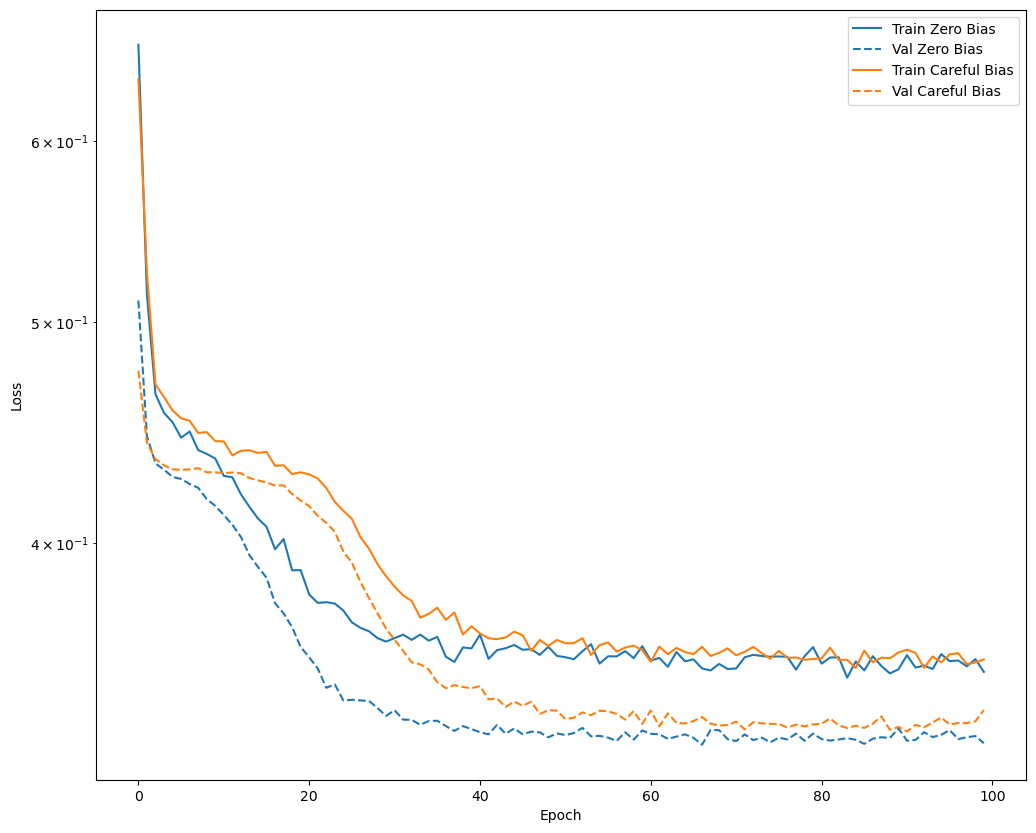

In [123]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [131]:
model = make_model(output_bias=0.0)
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0)

loss :  0.3403829038143158
compile_metrics :  0.3403829038143158

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Legitimate Transactions Detected (True Negatives):  1545
Legitimate Transactions Incorrectly Detected (False Positives):  54
Fraudulent Transactions Missed (False Negatives):  223
Fraudulent Transactions Detected (True Positives):  178
Total Fraudulent Transactions:  401


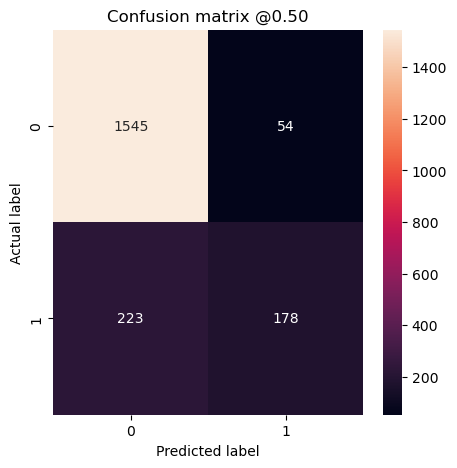

In [132]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, model.predict(test_features, batch_size=BATCH_SIZE))

In [133]:
model = make_model(output_bias=initial_bias)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0)

loss :  0.3369712233543396
compile_metrics :  0.3369712233543396

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
Legitimate Transactions Detected (True Negatives):  1553
Legitimate Transactions Incorrectly Detected (False Positives):  46
Fraudulent Transactions Missed (False Negatives):  231
Fraudulent Transactions Detected (True Positives):  170
Total Fraudulent Transactions:  401


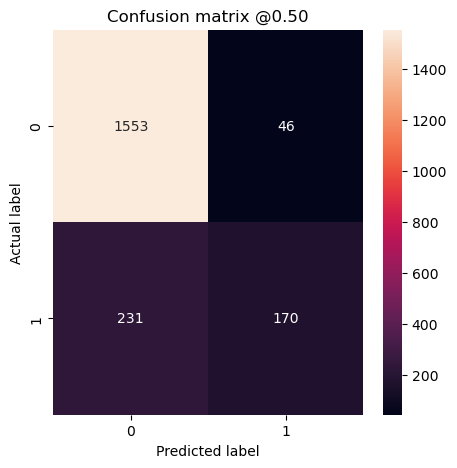

In [134]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, model.predict(test_features, batch_size=BATCH_SIZE))

# ⛔ Ignorer la suite ⛔

## Part 4 - Making the predictions and evaluating the model

### Predicting the result of a single observation

**Homework**

Use our ANN model to predict if the customer with the following informations will leave the bank: 

Geography: France

Credit Score: 600

Gender: Male

Age: 40 years old

Tenure: 3 years

Balance: \$ 60000

Number of Products: 2

Does this customer have a credit card ? Yes

Is this customer an Active Member: Yes

Estimated Salary: \$ 50000

So, should we say goodbye to that customer ?

In [ ]:
ann.predict(
    sc.transform(
        categorical_transformer.transform(
            [[600, 'France', 'Male', 40, 3, 60000, 2, 1, 1, 50000]]
        )
    )
)

**Solution**

### Predicting the Test set results

In [ ]:
y_pred = ann.predict(
    sc.transform(
        categorical_transformer.transform(
            X_test
        )
    )
) >= 0.5

In [ ]:
y_pred

### Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm=confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()
plt.show()
accuracy_score(y_test, y_pred)